In [1]:
!which python

/Users/ron/Documents/github/LLMs-from-scratch-main/.venv/bin/python


In [2]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

In [5]:
import torch
import torch.nn as nn


class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        # Use a placeholder for TransformerBlock
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        # Use a placeholder for LayerNorm
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits


class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # A simple placeholder

    def forward(self, x):
        # This block does nothing and just returns its input.
        return x


class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        # The parameters here are just to mimic the LayerNorm interface.

    def forward(self, x):
        # This layer does nothing and just returns its input.
        return x

In [6]:
import tiktoken
import torch 
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [7]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)

logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6754, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


# 4.2 Normalizing activations with layer normalization

In [8]:
torch.manual_seed(123)

In [12]:
batch_example = torch.randn(2,5)
batch_example

tensor([[ 0.2103, -0.3908,  0.2350,  0.6653,  0.3528],
        [ 0.9728, -0.0386, -0.8861, -0.4709, -0.4269]])

In [13]:
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
out

tensor([[0.7286, 0.6817, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1721, 0.0000, 0.0000, 0.0000, 0.8324, 0.1910]],
       grad_fn=<ReluBackward0>)

In [14]:
mean = out.mean(dim=-1, keepdim=True)

In [15]:
var = out.var(dim=-1, keepdim=True)
var

tensor([[0.1328],
        [0.1041]], grad_fn=<VarBackward0>)

In [16]:
norm = (out - mean)/torch.sqrt(var)
norm

tensor([[ 1.3543,  1.2256, -0.6450, -0.6450, -0.6450, -0.6450],
        [-0.0840, -0.6174, -0.6174, -0.6174,  1.9618, -0.0256]],
       grad_fn=<DivBackward0>)

In [ ]:
# unbiased = True -> population, unbiased = False -> sample stat

In [17]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
        
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased = False)
        norm_x = (x - mean) / torch.sqrt(var+self.eps)
        return self.scale * norm_x + self.shift

In [22]:
ln = LayerNorm(6)
output_norm = ln(out)

In [23]:
output_norm

tensor([[ 1.4835,  1.3425, -0.7065, -0.7065, -0.7065, -0.7065],
        [-0.0920, -0.6763, -0.6763, -0.6763,  2.1489, -0.0280]],
       grad_fn=<AddBackward0>)

In [24]:
output_norm.mean(dim=-1, keepdim=True)

tensor([[ 1.9868e-08],
        [-5.9605e-08]], grad_fn=<MeanBackward1>)

In [21]:
output_norm.var(dim=-1, keepdim=True)

tensor([[1.1999],
        [1.1999]], grad_fn=<VarBackward0>)

## 4.3 Implementing a feed forward network with GELU activations

In [25]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

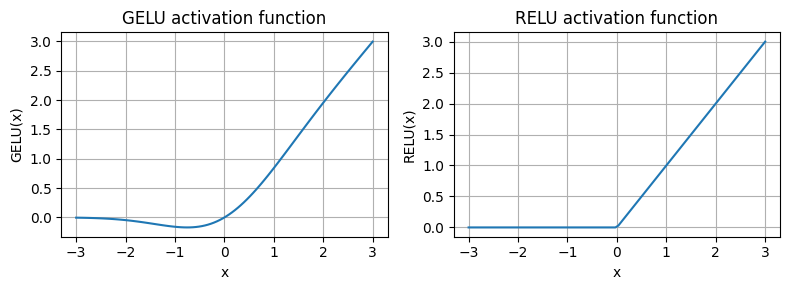

In [33]:
import matplotlib.pyplot as plt 
gelu, relu = GELU(), nn.ReLU()

## sample data ##
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize = (8,3) )

for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU","RELU"]),1):
    #print(i)
    #print((y, label))
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()


In [34]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

In [35]:
ffn = FeedForward(GPT_CONFIG_124M)

In [36]:
x = torch.rand(2, 3, 768)
ffn(x)

tensor([[[ 0.0497, -0.0930, -0.0704,  ..., -0.0139,  0.0147, -0.1315],
         [ 0.0576, -0.2214, -0.1170,  ...,  0.0506,  0.0159, -0.1953],
         [ 0.0413, -0.1992, -0.1227,  ..., -0.0109,  0.0488, -0.1375]],

        [[ 0.0866, -0.1370, -0.1714,  ...,  0.0209,  0.1446, -0.1926],
         [ 0.0818, -0.2232, -0.0816,  ...,  0.0469, -0.0109, -0.1947],
         [ 0.0978, -0.2053, -0.1547,  ..., -0.0274, -0.0032, -0.0921]]],
       grad_fn=<ViewBackward0>)

In [37]:
ffn

FeedForward(
  (layers): Sequential(
    (0): Linear(in_features=768, out_features=3072, bias=True)
    (1): GELU()
    (2): Linear(in_features=3072, out_features=768, bias=True)
  )
)

In [40]:
ffn.layers[0].weight

Parameter containing:
tensor([[ 1.4792e-02, -3.5260e-02, -2.1515e-03,  ...,  3.3267e-02,
         -3.5595e-02,  1.9927e-02],
        [-1.7002e-02, -2.5775e-02,  2.7952e-02,  ...,  2.3958e-02,
          3.1437e-02,  3.4429e-02],
        [ 8.1844e-03,  2.2992e-02,  8.5400e-05,  ..., -3.3540e-02,
          1.7129e-02, -3.7163e-03],
        ...,
        [ 2.8086e-02,  2.6808e-02, -4.1488e-03,  ..., -3.1250e-03,
         -2.7324e-02, -4.5724e-03],
        [-2.4667e-03, -1.2691e-02, -1.6941e-02,  ..., -4.5476e-03,
         -4.5686e-03, -3.4476e-02],
        [ 2.6358e-02, -3.7307e-03,  5.2950e-03,  ..., -5.1188e-03,
         -4.0859e-03,  6.9686e-03]], requires_grad=True)

## 4.4 Adding shortcut Connections

In [41]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])

    def forward(self, x):
        for layer in self.layers:
            # Compute the output of the current layer
            layer_output = layer(x)
            # Check if shortcut can be applied
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x


def print_gradients(model, x):
    # Forward pass
    output = model(x)
    target = torch.tensor([[0.]])

    # Calculate loss based on how close the target
    # and output are
    loss = nn.MSELoss()
    loss = loss(output, target)
    
    # Backward pass to calculate the gradients
    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            # Print the mean absolute gradient of the weights
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [42]:
layer_sizes = [3, 3, 3, 3, 3, 1]  

sample_input = torch.tensor([[1., 0., -1.]])

torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
)
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.0001201116101583466
layers.2.0.weight has gradient mean of 0.0007152041071094573
layers.3.0.weight has gradient mean of 0.0013988735154271126
layers.4.0.weight has gradient mean of 0.005049645435065031


In [43]:
torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=True
)
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169791162014008
layers.1.0.weight has gradient mean of 0.20694106817245483
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258540630340576


## 4.5 Connecting attention and linear layers in a transformer block

In [44]:
# If the `previous_chapters.py` file is not available locally,
# you can import it from the `llms-from-scratch` PyPI package.
# For details, see: https://github.com/rasbt/LLMs-from-scratch/tree/main/pkg
# E.g.,
# from llms_from_scratch.ch03 import MultiHeadAttention

from previous_chapters import MultiHeadAttention


class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"], 
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x

In [45]:
torch.manual_seed(123)
x = torch.rand(2, 4, 768)
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

In [46]:
output.shape

torch.Size([2, 4, 768])

In [47]:
x.shape

torch.Size([2, 4, 768])

## 4.6 Coding the GPT model

In [51]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        # Use a placeholder for TransformerBlock
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        # Use a placeholder for LayerNorm
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [52]:
torch.manual_seed(123)
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

batch = []

txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
print(batch)
batch = torch.stack(batch, dim=0)
print(batch)

[tensor([6109, 3626, 6100,  345]), tensor([6109, 1110, 6622,  257])]
tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [53]:
model = GPTModel(GPT_CONFIG_124M)
output = model(batch)

In [54]:
output.shape

torch.Size([2, 4, 50257])

In [55]:
batch.shape

torch.Size([2, 4])

In [56]:
batch.numel()

8

In [59]:
model.tok_emb.weight.shape


torch.Size([50257, 768])

In [60]:
model.out_head.weight.shape

torch.Size([50257, 768])

In [61]:
total_params = sum(p.numel() for p in model.parameters())
total_params

163009536

In [63]:
# model.tok_emb.weight and model.out_head.weight are shared
total_params - model.tok_emb.weight.numel()

124412160

## 4.7 Generating Text

In [65]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context
    for _ in range(max_new_tokens):
        
        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]
        
        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)
        
        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]  

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

In [66]:
start_context = "Hello, I am"

encoded = tokenizer.encode(start_context)
print("encoded:", encoded)

encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [67]:
model.eval() # disable dropout

out = generate_text_simple(
    model=model,
    idx=encoded_tensor, 
    max_new_tokens=6, 
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10


In [69]:
out.squeeze(0).tolist()

[15496, 11, 314, 716, 27018, 24086, 47843, 30961, 42348, 7267]

In [71]:
tokenizer.decode(out.squeeze(0).tolist())

'Hello, I am Featureiman Byeswickattribute argue'